In [9]:
import os

#is the notebook running on Colab?
if 'COLAB_JUPYTER_TRANSPORT' in os.environ.keys():
    isColab = True
    sourcedir =os.getcwd()+ "/CPlantBox"
    filedir = sourcedir +"/tutorial/jupyter/summer_school_2024"
else:
    isColab = False
    sourcedir = os.getcwd()+"/../../.."
    filedir = os.getcwd()
#this can take some minutes
if isColab:
    # downloading the source code
    ! git clone https://github.com/Plant-Root-Soil-Interactions-Modelling/CPlantBox --depth=1 --single-branch -b master
    os.chdir(sourcedir)
    !apt install libeigen3-dev
    ! apt install llvm-dev
    !pip3 install vtk
    !sudo DEBIAN_FRONTEND=noninteractive apt-get install -yq xvfb
    !pip install -q 'xvfbwrapper~=0.2.9'
    if 'vdisplay' not in globals():
        # start a virtual X display for MAGICAL rendering
        import xvfbwrapper
        vdisplay = xvfbwrapper.Xvfb()
        vdisplay.start()
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"


    if os.path.exists("./src/external/pybind11"):
        ! rm -rf src/external/pybind11 #delete folder
    ! git rm -r --cached src/external/pybind11 #take out git cache for pybind11
    ! git submodule add --force -b stable https://github.com/pybind/pybind11.git ./src/external/pybind11


    ! git pull
    ! cmake .
    ! make
    os.chdir(filedir)
    
    from google.colab import drive
    drive.mount('/content/drive')

# Workshop 6. 2024 - (1/4)

## CPlantBox basics

How to 

1. Simulate a root system 

2. Understanding model parameters 

3. Using confining geometry or obstacles

In [10]:
from IPython.display import SVG, display # to show svg files in the notebook

import sys; sys.path.append(sourcedir); sys.path.append(sourcedir+"/src")
import plantbox as pb 
import visualisation.vtk_plot as vp # for quick vizualisations

### 1. Simulate a root system

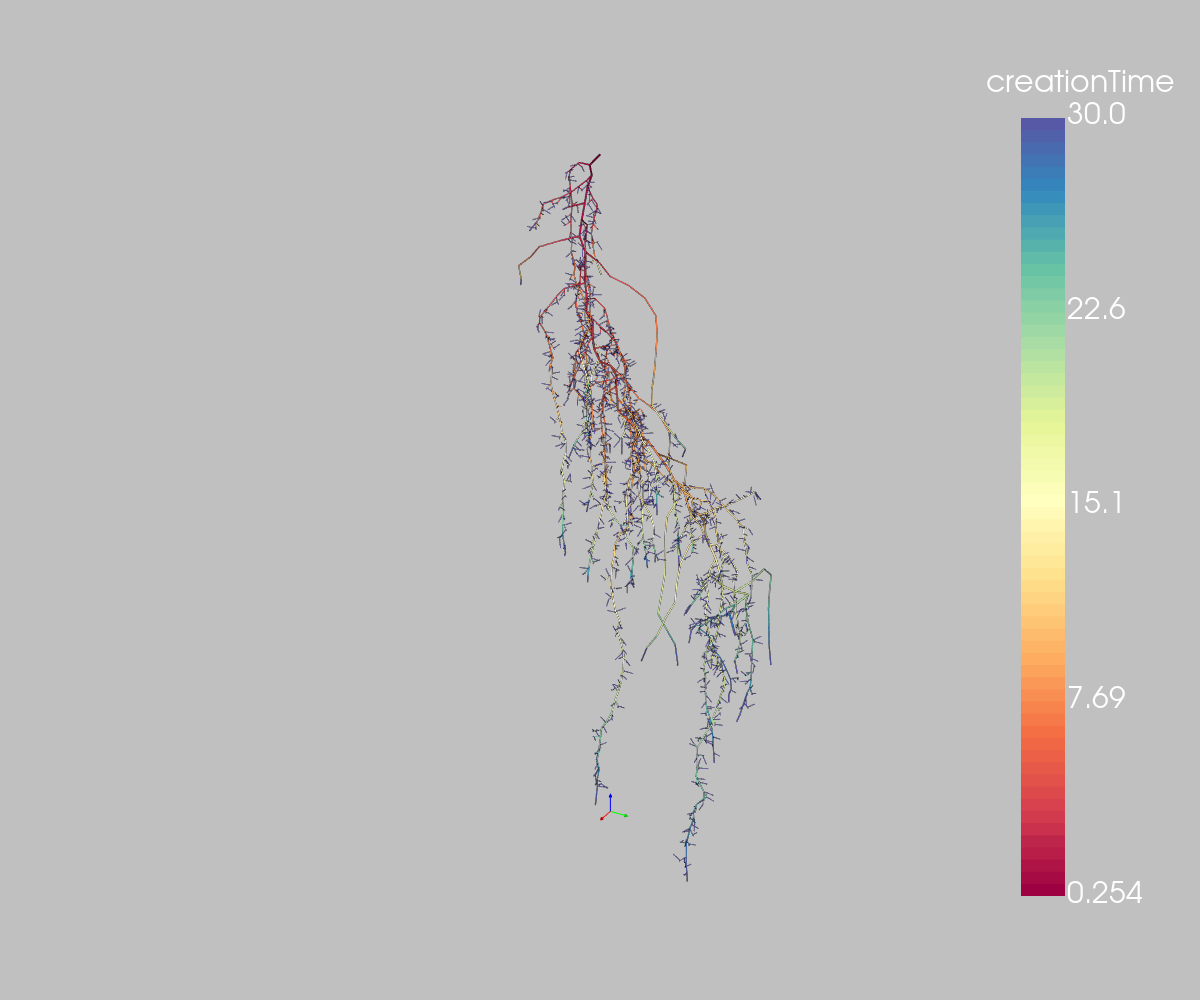

In [11]:
# Create instance describing a root system
rs = pb.RootSystem()

# Open plant and root parameter from a file
path = "../../../modelparameter/structural/rootsystem/"
name = "Anagallis_femina_Leitner_2010"
rs.readParameters(path + name + ".xml")
''
# Simulate
rs.initialize() 
rs.simulate(30) # [days]

# Export
rs.write("first_example.vtp") # for Paraview
rs.write("first_example.rsml") # e.g. gui/viewer/rsml_viewer.py

# Visualize
_ = vp.plot_roots(rs, "creationTime", interactiveImage = False) # Plot, using vtk (e.g. "subType")

Multiple root systems are created in the very same way, see *example2a_initializeparams.py* (in CPlantBox/tutorial/examples/python/).

In this way a multitude of differently shaped root systems can be created. 

In [23]:
display(SVG(filename='/content/drive/MyDrive/rootsystems.svg'))

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/rootsystems.svg'

### 2. Understanding model parameter

The seed contains the information to create the root system (and stem) and is defined by the class *SeedRandomParameter*. Each root type of emerging roots is represented by the class *RootRandomParameter*.

Specific plants and roots are presented by the classes *SeedSpecificParameter* and *RootSpecificParameter*. Instances of *SpecificParameter* classes are created (at organ creation) from the *RandomParameter* classes, usually by drawing specific random variables from a normal distribution, calling *RandomParameter::realize()*. 

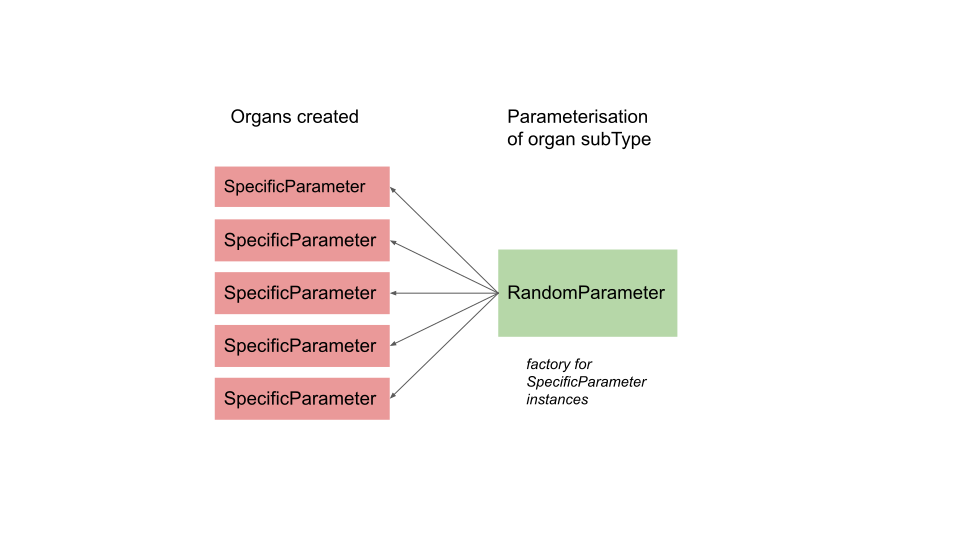

In [13]:
display(SVG(filename='/content/drive/MyDrive/parameters.svg'))

This holds for all organs in CPlantBox: Seed, Root, Stem, and Leaf.

In [14]:
random_parameters = rs.getRootRandomParameter()
for p in random_parameters[1:]: # CPlantBox subTypes start at index 1
    print(p)

[Parameters of primaryroot]
Variable		Value		Deviation		Description
===
gf                	1		0			Growth function number [1]
organType         	2		-			Organ type (unspecified organ = 0, seed = 1, root = 2, stem = 3, leaf = 4)
subType           	1		-			Unique identifier of this sub type
tropismT          	1		-			Type of root tropism (plagio = 0, gravi = 1, exo = 2, hydro, chemo = 3)
a                 	0.05		0			radius [cm]
colorB            	0.196078		-			Root color, blue component [0.-1.]
colorG            	0.392157		-			Root color, green component [0.-1.]
colorR            	0.431373		-			Root color, red component [0.-1.]
dx                	1		-			Axial resolution [cm] (maximal segment size)
dxMin             	1e-06		-			Axial resolution [cm] (minimal segment size)
la                	1.2		0			Apical zone [cm]
lb                	1		0			Basal zone [cm]
ldelay            	-1		0			Lateral root emergence delay [day]
lmax              	33.4		3.3			Maximal root length [cm]
ln                	

Most parameters are given by mean (parameter_name) and standard deviation (parameter_name+"s"). All random parameters can be accessed and changed (e.g. to reduce dx, or standard deviations)

Meaning of the variables of the *RootRandomParameter* class:

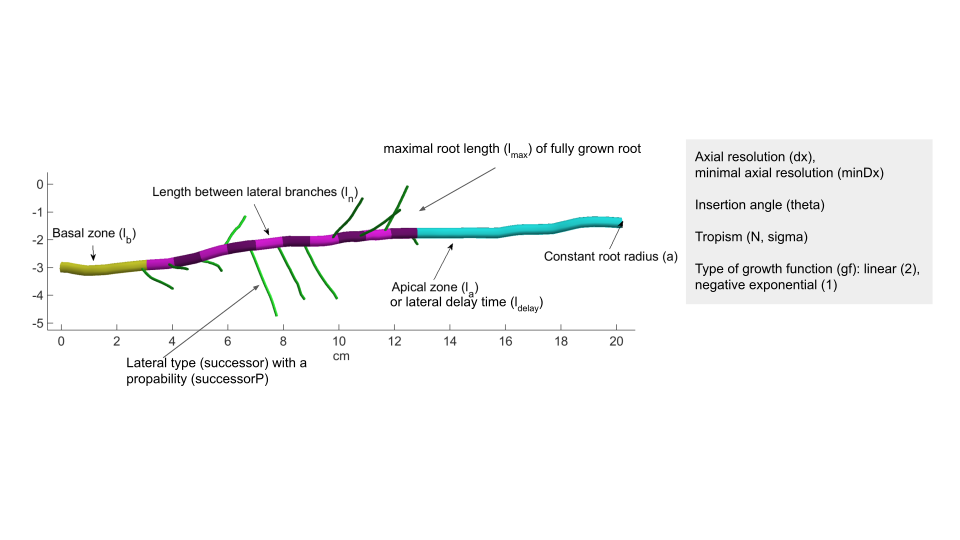

In [15]:
display(SVG(filename='/content/drive/MyDrive/root_random_parameters.svg'))

The tropism parameters are given by the type of tropism (tropismT), N and sigma

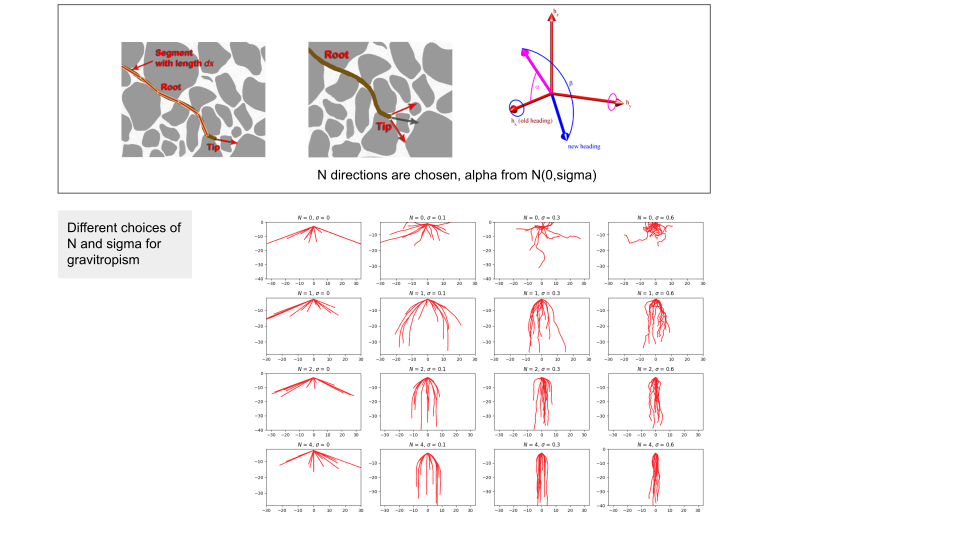

In [16]:
display(SVG(filename='/content/drive/MyDrive/tropisms.svg'))

The example figure for gravitropism was created with the script *example2b_tropism.py* from the tutorial with an inertion angle of 70 degree (note that the figure will look different with another inserion angle). 

In [17]:
random_parameter = rs.getRootSystemParameter() 
print(type(random_parameter)) # it is eady to reveal the class type in Python
print()
print(random_parameter)

<class 'plantbox.SeedRandomParameter'>

[Parameters of Anagallis_femina_Leitner_2010]
Variable		Value		Deviation		Description
===
delayDefinition   	0		-			method implemented to evaluate lateral growth delay (0: distance based, 1: delay based defined by parent organ)
maxTi             	0		0			Maximal number of tillers [1]
organType         	1		-			Organ type (unspecified organ = 0, seed = 1, root = 2, stem = 3, leaf = 4)
subType           	0		-			Unique identifier of this sub type
a                 	0.1		0			radius [cm]
delayB            	0		0			Time delay between the basal roots [day]
delayRC           	1000		0			Delay between the root crowns [day]
delaySB           	1000		0			Time delay between the shoot borne roots [day]
delayTi           	1e+09		0			Time delay between the tillers [day]
dx                	0.25		-			Axial resolution [cm] (maximal segment size)
dxMin             	1e-06		-			Axial resolution [cm] (minimal segment size)
firstB            	0		0			Emergence of first basal

Most of above parameters are not important for dicots or young monocots (and some are ignored: a, dx, dxMin), some are for whole plants only (maxTi, firstTi).

For root systems the most important parameters are:

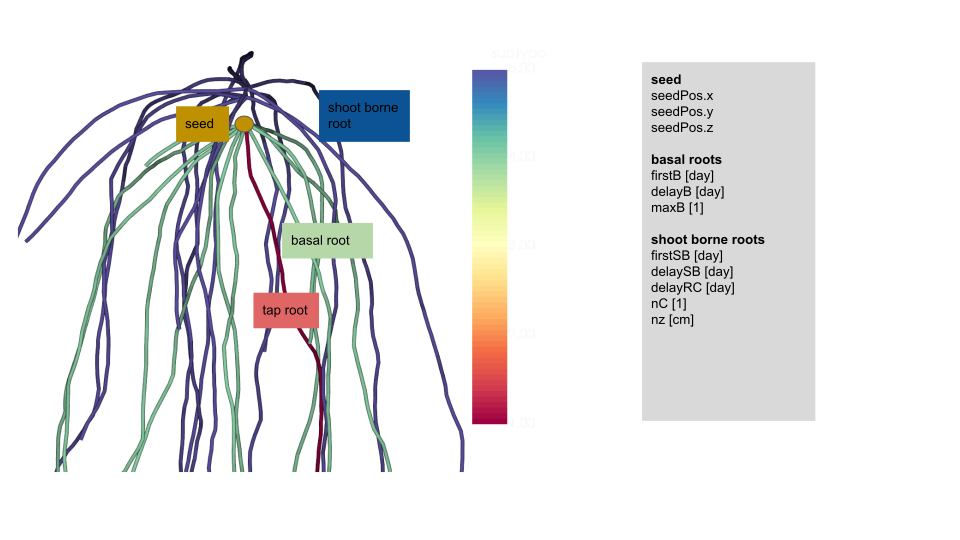

In [18]:
display(SVG(filename='/content/drive/MyDrive/seed_params.svg'))

Some notes on RootSystem.initialize():

In [19]:
# calling initialize will reset the simulation
rs.initialize(True) # verbose = True # will call initializeLB(4,5,verbose)
rs.initializeLB(4,5,True) # basal = 4, shootborne = 5, verbose = True # apical zone is length based
rs.initializeDB(4,5,True) # basal = 4, shootborne = 5, verbose = True # apical zone is delay based

rs.simulate(30) # [days]
# _ = vp.plot_roots(rs, "creationTime") # Plot, using vtk (e.g. "subType")

Access parameters:

In [20]:
print("Apical length of root subType", random_parameters[1].subType,"is", random_parameters[1].la, "cm")
random_parameters[1].la = 10
for p in random_parameters:
    print("Maximal root length for subType", p.subType, "is", p.lmax, "cm", "sd", p.lmaxs)

Apical length of root subType 1 is 1.2 cm
Maximal root length for subType 0 is 0.0 cm sd 0.0
Maximal root length for subType 1 is 33.400002 cm sd 3.3
Maximal root length for subType 2 is 7.6999998 cm sd 10.0
Maximal root length for subType 3 is 0.44 cm sd 0.039999999
Maximal root length for subType 4 is 0.40000001 cm sd 0.039999999


Change parameters, e.g. make the root system smaller

In [21]:
random_parameters[2].lmax = 1 # cm # subType 2 are the first order laterals
random_parameters[2].lmaxs = 0 # cm
rs.initialize() 
rs.simulate(30) 
_  = vp.plot_roots(rs, "subType", interactiveImage = False) # Plot, using vtk 

The modified parameter set can be saved as xml parameter file. XML files can be conveniently viewed in a web browser. 

In [22]:
rs.writeParameters("modified_"+name + ".xml")

Specific plant and root parameters can be accessed in similar way, but they should not be changed (since it is a simulation result), and it is simpler to obtain values using *getParameter*, which will be shown in the next Jupyter notebook.

You do not need a parameter file, everything can be defined in the Python script, see *example2a_initializeparams*.

### Take away messages

* Parameters are frequently given per mean and standard deviation (represented within the *RandomParameter* classes), when roots (or other plant organs) are created a specific parameter set is drawn from distributions (represented in the *SpecificParameter* class by calling *RandomParameter::realize()*).

* An idea what the more important parameters do, and how to modify the parameters in a Python script.

### 3. Simulate a full plant

The definition of full plants is similar to that of root systems. Only, there are new parameters to take into account.

In [15]:
import numpy as np
import matplotlib.pyplot as plt # for 2d plots

#create a plant from a parameter file
plant = pb.Plant()
path = "../../../modelparameter/structural/plant/"
name = "fspm2023"
plant.readParameters(path + name + ".xml")

# choose which organ parameters to overwrite
adaptSeed = False #change seed parameter
adaptRoot = False #change seed parameter
adaptLeaf = False #change leaf parameter
leafRadial = False #radial or not
adaptStem = False #change stem parameters
radialLeafShapeOptions = ["long","maple", "round", "flower"]
radialLeafShape = radialLeafShapeOptions[3]

Within the seed parameters are defined the number of tillers and basal roots. Roots and stems are (among others) defined according to their maximal lengths, growth rate and the distance between two children organs (roots, stems or leaves growing out of the organ in question).


In [16]:
if adaptSeed:
    srp = pb.SeedRandomParameter(plant)  # with default values
    srp.firstTil = 0  # [day] first emergence of a tiller
    srp.delayTil = 0  # [day] delay between the emergence of tillers
    srp.maxTil = 20 # [-] number of tillers 
    srp.firstB = 0  # [day] first emergence of a tiller
    srp.delayB = 0  # [day] delay between the emergence of tillers
    srp.maxB = 20 # [-] number of tillers 
    plant.setOrganRandomParameter(srp)
if adaptRoot:
    for p in plant.getOrganRandomParameter(pb.root):#we go through the root subtypes
        p.dxMin = 0.01 #resolution == minimum segment length
        p.dx = 0.1 #resolution == maximum segment length
        if p.subType == 1: #to which root subtype are the changes applied? Here: tap roots
            p.r = 10  # [cm/day] growth rate
            p.lmax = 20  # [cm] maximum length
            p.ln = 1 # [cm] interlateral distance
        plant.setOrganRandomParameter(p)
if adaptStem:
    for p in plant.getOrganRandomParameter(pb.stem):
        p.dxMin = 0.01 #resolution == minimum segment length
        p.dx = 0.1 #resolution == maximum segment length
        p.r = 10  # [cm/day] growth rate
        p.lmax = 20  # [cm] maximum length
        p.ln = 1 # [cm] interlateral distance
        plant.setOrganRandomParameter(p)

The leaf parameters can be adapted to represent different leaf 2D shapes. The 2D shapes can be defined according to the distance from the leaf center vain (non-radial geometry) or according to the distance from the leaf center (radial geometry).

In [17]:
if adaptLeaf:
    for p in plant.getOrganRandomParameter(pb.leaf):
        if leafRadial:
            if radialLeafShape=="long":
                p.lb =  1 # length of leaf stem
                p.la,  p.lmax = 3.5, 8.5
                p.areaMax = 10  # cm2, area reached when length = lmax
                N = 100  # resolution of the leaf shape
                phi = np.array([-90, -45, 0., 45, 90]) / 180. * np.pi
                l = np.array([3, 2.2, 1.7, 2, 3.5]) #distance from leaf center

            elif radialLeafShape == "maple":
                p.lb =  1 # length of leaf stem
                N = 100  # resolution of the leaf shape
                p.areaMax = 50 
                p.la,  p.lmax = 5, 11
                phi = np.array([-90, -45, 0., 45,67.5,70, 90]) / 180. * np.pi
                l = np.array([2, 2, 2, 4,1,1, 4]) #distance from leaf center

            elif radialLeafShape == "round":
                p.lb =  1 # length of leaf stem
                N = 100  # resolution of the leaf shape
                p.la,  p.lmax = 5, 11
                p.areaMax = 3.145*(((p.lmax-p.la - p.lb)/2)**2)
                phi = np.array([-90, -45, 0., 45,67.5,70, 90]) / 180. * np.pi
                l_ = (p.lmax - p.lb - p.la)/2
                l = np.array([l_ for x_i in range(len(phi))]) 

            elif radialLeafShape == "flower":
                N = 100  # resolution of the leaf shape
                p.areaMax = 100 
                p.la, p.lb, p.lmax = 5, 1, 11
                phi = np.array([-90., -67.5, -45, -22.5, 0, 22.5, 45, 67.5, 90]) / 180. * np.pi
                l = np.array([5., 1, 5, 1, 5, 1, 5, 1, 5])

            p.createLeafRadialGeometry(phi, l, N)   

        else:
            p.parametrisationType=1
            p.lb =  2 # length of leaf sheath
            p.la,  p.lmax = 3.5, 8.5
            p.areaMax = 10  # cm2, area reached when length = lmax
            N = 100  
            y = np.array([-3, -2.1, 0., 2.45, 3.5])
            l = np.array([0., 1.54, 1.7, 1.26, 0.])
            p.createLeafGeometry(y, l, N)         


        p.tropismT = 1 # 1: gravitropism
        #p.tropismN = 5
        #p.tropismS = 0.1
        plant.setOrganRandomParameter(p)

CPlantBox offers the option to print several vtk files to create a video of the growth in Paraview. When running the simulation on Colab, it is possible to print images at regular intervals.

2D leaf shape of a full grown leaf


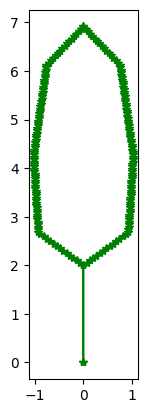

In [18]:
verbose = False
plant.initialize(verbose)
# Simulate
plant.simulate(30, verbose)
# Plot, using vtk
vp.plot_plant(plant, "organType",interactiveImage = not isColab)

# zoom on one leaf--theoreticall 2D shape once fully grown
leaves = plant.getOrgans(pb.leaf)
if len(leaves)>0:
    print("2D leaf shape of a full grown leaf")
    lorg = leaves[0]
    lrp = lorg.getLeafRandomParameter()  
    if leafRadial:
        yy = np.linspace(0, lorg.leafLength(), N)
        geom_x, geom_y = [],[]
        for i, x in enumerate(lrp.leafGeometry):
            geom_x.extend(x)
            geom_y.extend([yy[i]] * len(x))
        geom_x = np.array(geom_x)
        geom_y = np.array(geom_y)        
        a  = lorg.leafArea() / lorg.leafLength() # scale radius
        plt.plot(geom_x * a, geom_y, "g*")
        plt.plot(-geom_x * a, geom_y, "g*")

    else:
        geom_x_a =  np.array([0])
        geom_x_b = np.array([ x[-1] for x in lrp.leafGeometry]) #normalized x value along length
        geom_x = np.concatenate((geom_x_a,geom_x_b))
        geom_y_a = np.array([0])
        geom_y_b =np.linspace(lrp.lb, lorg.leafLength()+lrp.lb, len(geom_x_b))
        geom_y = np.concatenate((geom_y_a,geom_y_b))
        a  = lorg.leafArea() / lorg.leafLength() # scale radius
        plt.plot(geom_x * a, geom_y, "g-*")
        plt.plot(-geom_x * a, geom_y, "g-*")
    plt.ylim([0, lrp.lmax+1])
    plt.xlim([-a-1, a+1])
    plt.axis('scaled')
    plt.show()
else:
    print("no leaves created")

### 4. Use of confining geometry or obstacles

Confining geometry and obstacles can be defined using signed distance functions (SDF), classes are defined in *src/sdf.h*. 

Its always a good idea to define the soil volume (even if unconstrained), because otherwise roots may grow upwards out of the soil (which is normally not to be expected)!

In [19]:
rs = pb.RootSystem()
path = "../../../modelparameter/structural/rootsystem/" # Open plant and root parameter from a file
name = "Zea_mays_4_Leitner_2014"
rs.readParameters(path + name + ".xml")
rs.setGeometry(pb.SDF_PlantBox(1.e6,1.e6,1.e6)) # length, width, height [-5.e5,5.e5] [-5.e5,5.e5] [0.,-1.e6]
rs.initialize()
rs.simulate(60)  # days
_ = vp.plot_roots(rs, "creationTime", interactiveImage = False) 

OrganRandomParameter::readSuccessor: for parameter of organ 2, subType 1, 'ruleId' (and 'number') not found in successor definition. Use defeault ruleId instead: 0
OrganRandomParameter::readSuccessor: for parameter of organ 2, subType 2, 'ruleId' (and 'number') not found in successor definition. Use defeault ruleId instead: 0
OrganRandomParameter::readSuccessor: for parameter of organ 2, subType 3, 'ruleId' (and 'number') not found in successor definition. Use defeault ruleId instead: 0
Seed::initialize: RootSystem 
writing VTP... first_example.vtp
writing RSML... first_example.rsml
Seed::initialize: RootSystem 
Seed::initialize: RootSystem 
Seed::initialize: RootSystem 
Seed::initialize: RootSystem 
OrganRandomParameter::readSuccessor: for parameter of organ 2, subType 1, 'ruleId' (and 'number') not found in successor definition. Use defeault ruleId instead: 0
Seed::initialize: RootSystem 
Seed::initialize: Basal root type #4 was not defined, using tap root parameters instead


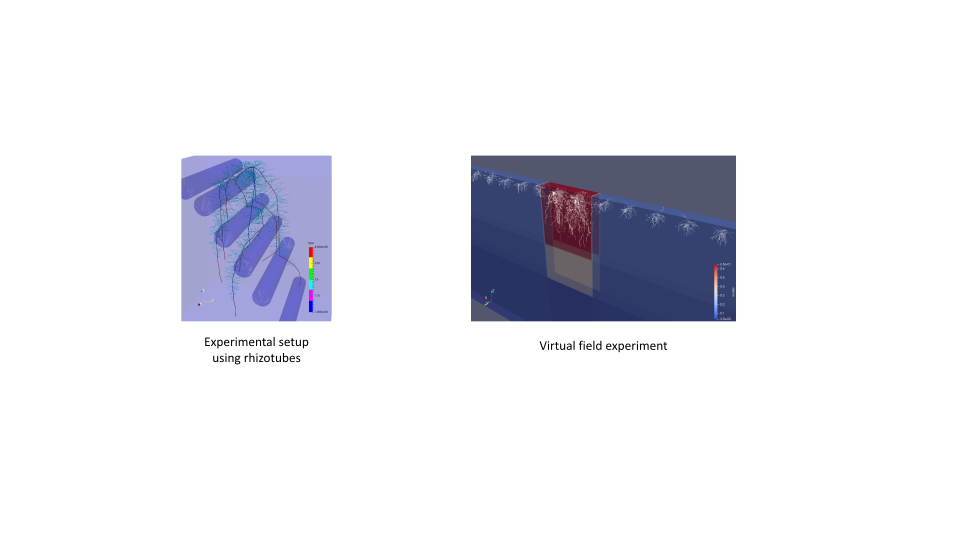

In [20]:
display(SVG(filename='/content/drive/MyDrive/geometry.svg'))

The following example is part of *example1c_complexcontainer.py* and describes a split box experiment

In [21]:
topBox = pb.SDF_PlantBox(22, 20, 5) # length, width, height [cm]
sideBox = pb.SDF_PlantBox(10, 20, 35)
left = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(-6, 0, -5))
right = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(6, 0, -5))
box_ = [topBox, left, right]
splitBox = pb.SDF_Union(box_)
print("distance to next boundary", topBox.getDist(pb.Vector3d(0, 0, -3)), "cm")

distance to next boundary -2.0 cm


In [8]:
rs.setGeometry(splitBox)
rs.initialize()
rs.simulate(60)  # days
rs.write("splitbox.vtp")
_ = vp.plot_roots(rs, "creationTime", interactiveImage = False) 

NameError: name 'splitBox' is not defined

The implemented functions can be found in src/sdf.h, and src/sdf.cpp. Set operations can be used on SDF. In this way obstacles are implemented, e.g. pb.SDF_Difference(soil_geom, obstacle_geom).

More examples are given in *example1c_complexcontainer.py*. 

Visualization of the geometry can be achieved by writing a Paraview Python macro:

In [23]:
rs.write("splitbox.py") # can be run by Paraview

### Take away messages

1. Geometry is defined by signed distance functions

2. It is alway a good idea to constrain the root system to the soil domain 